In [178]:
# for auto-reloading extensions - helpful if you're writing and testing a package
%reload_ext autoreload
%autoreload 2

# for inline plotting in python using matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# for easier plots - also makes matplotlib plots look nicer by default
import seaborn as sns

# set up for using plotly offline without an API key - great for interactive plots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.figure_factory as ff
init_notebook_mode(connected=True)

# for numerical work
import pandas as pd
import numpy as np

import pymongo

import datetime
import time
import json

from pandas.io.json import json_normalize
from pymongo import MongoClient

import pickle

from confluent_kafka import Producer

import bson
from bson import json_util

import math

from einsteinds import db as edb
from einsteinds import event_processing
from einsteinds import ml
from einsteinds import plots
from einsteinds import utils


from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, scale
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers


clean_events = event_processing.clean_events

# load the database credentials from file
with open('../creds/local_creds.json') as json_data:
    creds = json.load(json_data)

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [3]:
# initialize the database
db = edb.Database(creds)

In [4]:
# get the request summaries for the month of January and February
request_summaries = db.get_summarized_request_sets(start_date=datetime.datetime(2018,1,1), end_date=datetime.datetime(2018,3,1))

Reading Requests from the Database
Flattening Request Sets
Generating summary features


/home/kitson/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning:

Degrees of freedom <= 0 for slice.

/home/kitson/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1315: RuntimeWarning:

invalid value encountered in subtract



In [5]:
request_summaries_with_fraud = db.add_fraud_label(request_summaries, 'user_email')

In [200]:
normal_requests = request_summaries_with_fraud[request_summaries_with_fraud.fraud == False]
fraud_requests = request_summaries_with_fraud[request_summaries_with_fraud.fraud == True]

X = normal_requests.replace([np.nan, np.inf], 0).drop(['user_email','fraud'], axis=1).values.astype('float')
X_fraud = fraud_requests.replace([np.nan, np.inf], 0).drop(['user_email','fraud'], axis=1).values.astype('float')
X_all = request_summaries_with_fraud.replace([np.nan, np.inf], 0).drop(['user_email','fraud'], axis=1).values.astype('float')

In [192]:
ss = StandardScaler()
ss.fit(X)

scaled_X = ss.transform(X)

X_train, X_test = train_test_split(scaled_X, test_size=0.2, random_state=1983)

In [193]:
def build_autoencoder(input_dim, encoded_dim, reduction_factor, X_train, X_test):
    
    # reduce the layer size
    current_dim = math.ceil(input_dim/reduction_factor)
    
    layer_sizes = []
    
    input_layer = Input(shape=(input_dim,))
    encoded = input_layer
                    
    while current_dim > encoded_dim:
    
        encoded = Dense(current_dim, activation='relu')(encoded)
        layer_sizes.append(current_dim)
        current_dim = math.ceil(current_dim/reduction_factor)
        
    
    encoded = Dense(encoded_dim, activation='relu', name='encoder')(encoded)

    decoded = Dense(layer_sizes.pop(), activation='relu')(encoded)
    
    while len(layer_sizes) > 0:
        
        size = layer_sizes.pop()
        decoded = Dense(size, activation='relu')(decoded)

    decoded = Dense(input_dim, activation='tanh')(decoded)
                   
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
                        
    autoencoder.compile(optimizer='adadelta', loss='mse')
    
    autoencoder.fit(X_train, X_train,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(X_test, X_test))
    
    print(autoencoder.summary())
                        
    return autoencoder

In [194]:
autoencoder = build_autoencoder(input_dim=scaled_X.shape[1], encoded_dim=10, reduction_factor=2, X_train=X_train, X_test=X_test)

Train on 10958 samples, validate on 2740 samples
Epoch 1/100
10958/10958 [==============================] - 3s 251us/step - loss: 0.9885 - val_loss: 0.9350
Epoch 2/100
10958/10958 [==============================] - 0s 44us/step - loss: 0.9099 - val_loss: 0.8536
Epoch 3/100
10958/10958 [==============================] - 1s 47us/step - loss: 0.8822 - val_loss: 0.8466
Epoch 4/100
10958/10958 [==============================] - 1s 47us/step - loss: 0.8727 - val_loss: 0.8357
Epoch 5/100
10958/10958 [==============================] - 0s 42us/step - loss: 0.8616 - val_loss: 0.8266
Epoch 6/100
10958/10958 [==============================] - 0s 43us/step - loss: 0.8483 - val_loss: 0.8115
Epoch 7/100
10958/10958 [==============================] - 1s 49us/step - loss: 0.8341 - val_loss: 0.7999
Epoch 8/100
10958/10958 [==============================] - 1s 46us/step - loss: 0.8244 - val_loss: 0.7917
Epoch 9/100
10958/10958 [==============================] - 0s 45us/step - loss: 0.8177 - val_loss: 0.7

In [183]:
def calculate_squared_errors(X, autoencoder):
    
    X_predicted = autoencoder.predict(X)
    
    errors = X_predicted - X
    
    def squared_error(x):
        return np.sum(np.power(x, 2))

    squared_errors = np.apply_along_axis(squared_error, axis=1, arr=errors)
    
    return squared_errors

In [195]:
serrors_normal = calculate_squared_errors(scaled_X, autoencoder)

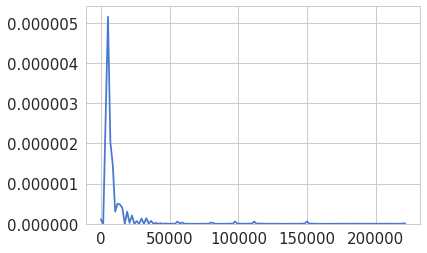

In [196]:
sns.distplot(serrors_normal, hist=False)

In [202]:
X_fraud_scaled = ss.transform(X_fraud)
X_all_scaled = ss.transform(X_all)

In [203]:
serrors_fraud = calculate_squared_errors(X_fraud_scaled, autoencoder)
serrors_all = calculate_squared_errors(X_all_scaled, autoencoder)

100897.06003343545
6409.070642205672


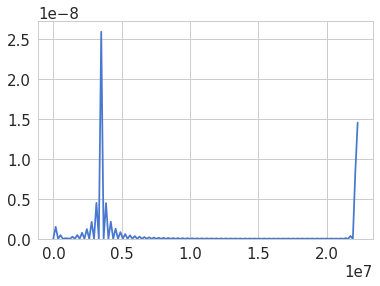

In [223]:
sns.distplot(serrors_fraud, hist=False)

print(np.mean(serrors_fraud))
print(np.median(serrors_fraud))

9977.877189640414
9.927545226899362


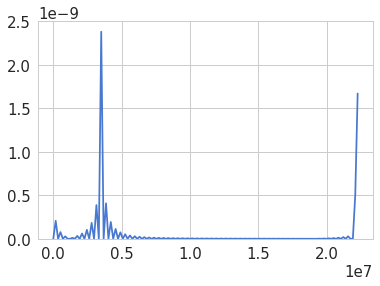

In [224]:
sns.distplot(serrors_all, hist=False)

print(np.mean(serrors_all))
print(np.median(serrors_all))

In [206]:
request_summaries_with_fraud['squared_errors'] = serrors_all

In [221]:
request_summaries_with_fraud.groupby('fraud')['squared_errors'].median()

fraud
False       6.277936
True     6409.070642
Name: squared_errors, dtype: float64

It looks like there's an obvious relationship between the squared error of the autoencoder and the 

In [216]:
by_user = request_summaries_with_fraud.groupby(['user_email', 'fraud'])['squared_errors'].aggregate(['count','min','max','mean','median','sum']).reset_index()
by_user['serror_per_request'] = by_user['sum']/by_user['count']

In [219]:
by_user.groupby(['fraud'])[['sum','serror_per_request']].mean()

,sum,serror_per_request
fraud,,
False,1.883180e+03,167.379540
True,4.285157e+06,23470.480789
